## Infomap + NetworkX
Generate and draw a network with NetworkX, colored
according to the community structure found by Infomap.


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
%pylab



Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [20]:
infomap_path = '~/infomap/Infomap'

def infomap(net_path, altmap=False):
    out_path = './output/'
    args = '-2 -u -vvv'
    if altmap:
        args += ' --altmap'
        
    os.system(infomap_path + ' ' + net_path + ' ' + out_path + ' ' + args)

def read_tree(tree_path):    
    df = pd.read_csv(tree_path, sep=' ', header = 1)
    df.columns = ['community', 'flow', 'name', 'node', 'trash']
    df = df.drop(['flow', 'trash'], axis=1)
    
    for i, path in enumerate(df['community']):
        df.iloc[i,0] = path[0]
        
    return df

def plogq(p, q):
    if q < 1e-18:
        print (f'Unexpected zero operand in plogq: p={p}, q={q}\n.')
        return 0.0
    
    return p*np.log2(q)

def plogp(p):
    if p < 1e-18:
        return 0.0
    
    return p*np.log2(p)

def drawNetwork(G, communities):
    # position map
    pos = nx.spring_layout(G)
    # community ids
    #communities = [v for k,v in nx.get_node_attributes(G, 'community').items()]
    communities = [v for v in communities.values()]
    print (len(communities))
    print (len(G.nodes))
    # Draw edges
    nx.draw_networkx_edges(G, pos)

    # Draw nodes
    nodeCollection = nx.draw_networkx_nodes(G,
        pos = pos,
        node_color = communities,
        cmap = plt.get_cmap('Set3') 
    )

    # Draw node labels
    for n in G.nodes():
        plt.annotate(n,
            xy = pos[n],
            textcoords = 'offset points',
            horizontalalignment = 'center',
            verticalalignment = 'center',
            xytext = [0, 0],
            color = 'k'
        )

    plt.axis('off')
    plt.show()


In [11]:

# params
out_path = './output/'
filename = 'test'


In [72]:
num_cliques = 3
clique_size = 10
N = num_cliques * clique_size # num nodes
G = nx.ring_of_cliques(num_cliques, clique_size)
G = nx.convert_node_labels_to_integers(G, first_label=1)


In [76]:
N = 20 # num nodes
G = nx.MultiGraph()
G.add_nodes_from(range(1, N+1))

for n in range(1,N):
    G.add_edge(n, n+1, weight=1)

G.add_edge(1, int(N/2), weight=1)
G.add_edge(int(N/2) + 1, N, weight=1)



0

In [81]:

nx.write_pajek(G, out_path +  filename + '.net')
infomap(out_path +  filename + '.net', altmap=True)



/home/chri/anaconda3/lib/python3.6/site-packages/networkx/readwrite/pajek.py:77: UserWarning: Node attribute community is not processed. Non-string attribute.
  'Non-string attribute'))


{11: 1, 20: 1, 12: 1, 13: 1, 14: 1, 15: 1, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2, 10: 3, 1: 3, 2: 3, 9: 3, 16: 4, 17: 4, 18: 4, 19: 4}
We found 4 communities.
20
20


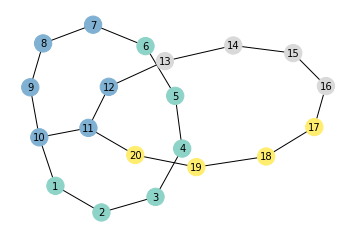

In [83]:

#G = nx.read_pajek(net_path)
df = read_tree(out_path +  filename + '.tree')


communities = {}
for index, row in df.iterrows():
    node = int(row['node'])
    communities[node] = int(row['community'])

nx.set_node_attributes(G, name='community', values=communities) # seems to be faulty!!
#print (nx.get_node_attributes(G, name='community'))

print (communities)
num_communities = max(communities.values())
print (f'We found {num_communities} communities.')


# print network
plt.close('all')
plt.figure()
drawNetwork(G, communities)



In [84]:

# compute stationary and conditional distribution for the nodes
pagerank = nx.pagerank_numpy(G, alpha=0.9)
p_nodes = np.array([ val for val in pagerank.values()])

p_node_transitions = nx.google_matrix(G, alpha=1.0)


# compute stationary and joint distribution for the communities
p_comm = np.zeros(num_communities)
p_comm_stay = np.zeros(num_communities)
for alpha,node in enumerate(G.nodes):
    comm_idx = communities[node] - 1
    p_comm[comm_idx] += p_nodes[alpha]
    
    neighbors = nx.all_neighbors(G, node)
    for neighbor in neighbors:
        beta = neighbor - 1
        if communities[node] == communities[neighbor]:
            p_comm_stay[comm_idx] += p_nodes[alpha] * p_node_transitions[alpha,beta]

# compute altmap cost
epsilon = 1e-18 # vicinity threshold for numerical stability

cost = 0.0
for i in range(num_communities):
    
    # check for edge cases
    if (p_comm_stay[i] < epsilon) or (p_comm_stay[i] + p_comm_stay[i] > 1.0):
        continue
    
    p_comm_leave = 1.0 - p_comm_stay[i]
    
    cost += plogp(p_comm_stay[i]) - 2.0 * plogq(p_comm_stay[i], p_comm[i])
    cost += plogp(p_comm_leave) - plogq(p_comm_leave, p_comm[i] * (1.0 - p_comm[i]))

cost = -cost
print (cost)

-8.175139784881972
